A convolutional network for predicting fashion items (shirts, shoes, etc.)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms, utils, datasets
from torch.nn.parameter import Parameter
import pdb

## Part 1

In [56]:
#A class implementing a convolution on a layer
class Conv2d(nn.Module):
    def  __init__(self, n_channels, out_channels, kernel_size, stride=1, 
                  padding=0, dilation=1, groups=1, bias=True):
        self.__dict__.update(locals())
        super(Conv2d, self).__init__()

        self.weight = Parameter(torch.Tensor(out_channels, 
                               n_channels, 
                               *kernel_size))
        self.bias = Parameter(torch.Tensor(out_channels))
    
        self.weight.data.uniform_(-.1,.1) #Part 2
        self.bias.data.uniform_(0,0)
    
    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride, 
                        self.padding, self.dilation, self.groups)
    
    
#A class implementing cross entropy loss
class CrossEntropy(nn.Module):
    def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
        self.__dict__.update(locals())
        super(CrossEntropy, self).__init__()
        
    
    def forward(self, y_hat, y_truth):
        #Following a formula for cross entropy loss
        values,_ = torch.max(y_hat, 1, keepdim=True)
        g = y_hat
        g = torch.exp(g - values)
        g = g/(g.sum(1,keepdim=True))
        user = g[torch.arange(y_hat.size(0)),y_truth]
        losses = -torch.log(user.clamp(1e-40))
        return(torch.mean(losses))

#A class for the convolutional network
class ConvNetwork(nn.Module):
    def __init__(self, dataset):
        super(ConvNetwork, self).__init__()
        x, y = dataset[0]
        c, h , w = x.size()
        output = 10
        
        self.net = nn.Sequential(
          Conv2d(c, 20, (3,3), padding =(1,1)),
          nn.ReLU(), 
          Conv2d(20,10, (5,5), padding = (2,2)),
          nn.ReLU(),
          Conv2d(10, output, (28,28), padding =(0,0)),
            
        )
        
    def forward(self,x):
        return self.net(x).squeeze(2).squeeze(2)

#A class for uploading the fashion dataset
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self,root, train=True):
        self.data = datasets.FashionMNIST(root, train=train, transform=transforms.ToTensor(), download = True)

    
    def __getitem__(self, i):
        x, y = self.data[i]
        return x, y
    
    def __len__(self):
        return len(self.data)
    
#Load the dataset 
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

#Initialize the model, loss, and optimizer
model = ConvNetwork(train_dataset)
model = model.cuda()
my_objective = CrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

#Create the data loaders 
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)

#Create lists to keep track 
my_losses = []
val_losses = []
val_avg_loss = []
loop = tqdm(total=len(train_loader)*6, position=0)
counter = 0
for epoch in range(6):
    
    #Load the data
    for x, y_truth in train_loader:
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True) 
        
        #Get the gradientand losses
        optimizer.zero_grad()
        y_hat = model(x)
        my_loss = my_objective(y_hat, y_truth)
        my_losses.append(my_loss.item())
        
        #Update the update bar
        loop.set_description('loss:{:.4f}'.format(my_loss.item()))
        loop.update(1)
        
        #Update the model
        my_loss.backward()
        optimizer.step()
        
        #Only do the validation every 100 batches
        if (counter % 100 == 0):
            for x, y_truth in val_loader:
                x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

                y_hat = model(x)
                loss = my_objective(y_hat, y_truth)

                val_losses.append(loss.item())
            val_avg_loss.append(np.mean(val_losses))
            val_losses.clear()
        counter+=1    
            

loop.close()


loss:0.8001: 100%|██████████| 8574/8574 [02:09<00:00, 65.96it/s] 


## Part 3

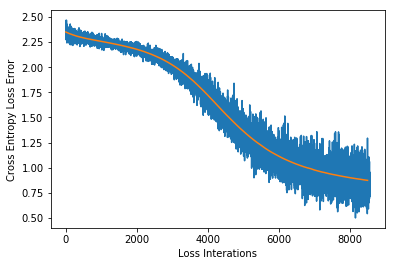

In [57]:
#Plot my Losses
plt.plot(my_losses)
plt.plot(range(0,8600,100), val_avg_loss)
plt.xlabel("Loss Interations")
plt.ylabel("Cross Entropy Loss Error")
plt.show()

In [58]:
#Get the parameters and accuracy to see how the model did
total = sum([np.prod(p.size()) for p in model.parameters()])
print("Total Parameter Size: " +str(total))

acc = (torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean()
print("Total Accuracy: %" + str(acc.item()*100))

Total Parameter Size: 83620
Total Accuracy: %70.83333730697632


## Part 4

Practicing the sizing of using convolutional networks.

Using a Kernel size of 3x3:  W2=(W1−F+2P)/S+1       H2=(H1−F+2P)/S+1

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3, 3), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3, 3), padding=(2, 2))

(c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3, 3), padding=(6, 6))

Using a Kernel size of 5×5:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2, 2))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(3, 3))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(9, 9))

Using Kernel size of 5×3:

(c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(0, 1))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(1, 2))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(2, 3))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(8, 9))

Determine the kernel that requires the smallest padding size to make the following mappings possible:

(c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size=(2, 4), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(1, 1), padding=(0, 0))